In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [3]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [4]:
def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe

    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview

    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())



In [5]:
def read_data(file_path):

    """
    This function reads the accelerometer data from a file

    Args:
        file_path: URL pointing to the CSV file

    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


In [6]:
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


In [7]:
# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


In [8]:
def plot_axis(ax, x, y, title,color="red"):

    ax.plot(x, y,color=color)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    

In [9]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()



In [10]:
def create_segments_and_labels(df, time_steps=80, step=40, label_name=""):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    print(segments)
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [11]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.3.1



--- Load, inspect and transform data ---

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.

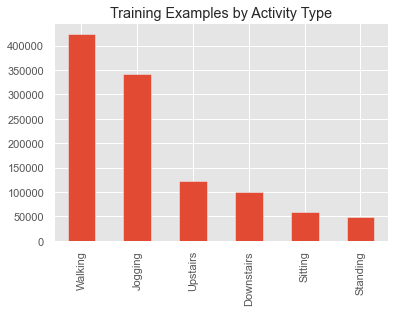

In [12]:
print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('../Data/WISDM_ar_v1.1_raw.txt')

# Describe the data
show_basic_dataframe_info(df, 20)

df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

In [13]:
print(df['user-id'].max())
print(df['user-id'].min())

36
1


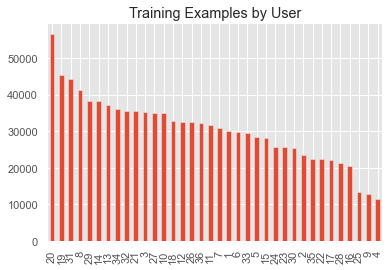

In [14]:
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()


In [15]:
def plot_axis(ax, x, y, title,color="red",label="alpa"):
    ax.plot(x, y,color=color,label=label)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    # 
np.unique(df["activity"])


array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

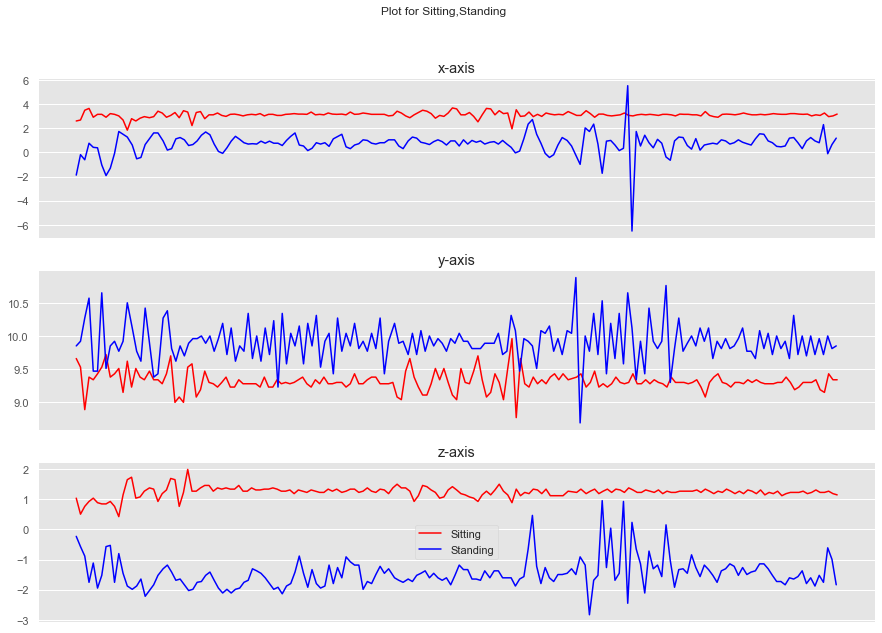

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(15, 10),sharex=True)

colors = ["red","blue","cyan","green","black","yellow","magenta"]
colors.reverse()
max_time = 0
activities = ['Sitting', 'Standing']
for activity in activities:
  subset = df[df["activity"] == activity][:180]
  min_timestamp = subset['timestamp'].min()
  t_stamp = subset['timestamp'].copy()-min_timestamp
  color = colors.pop()
  if max_time<t_stamp.max():
    max_time = t_stamp.max()
  plot_axis(ax0, t_stamp, subset['x-axis'], 'x-axis',color=color,label=activity)
  plot_axis(ax1, t_stamp, subset['y-axis'], 'y-axis',color=color,label=activity)
  plot_axis(ax2, t_stamp, subset['z-axis'], 'z-axis',color=color,label=activity)


# ax0.set_ylim([0, max_time])
ax0.grid(True)
# plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(top=0.90)
fig.suptitle("Plot for "+','.join(activities))
plt.legend()
plt.show()


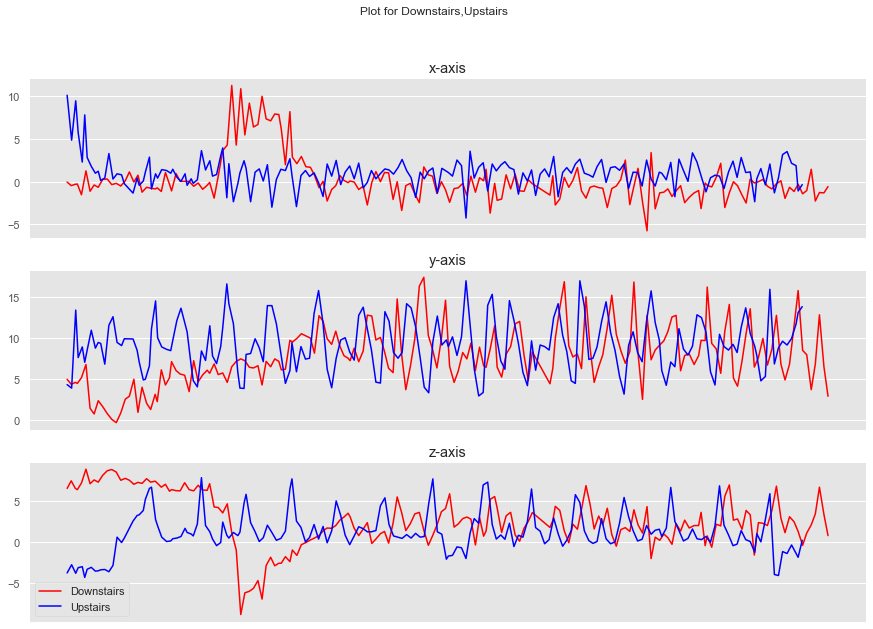

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(15, 10),sharex=True)

colors = ["red","blue","cyan","green","black","yellow","magenta"]
colors.reverse()
max_time = 0
activities = ['Downstairs', 'Upstairs']
for activity in activities:
  subset = df[df["activity"] == activity][:180]
  min_timestamp = subset['timestamp'].min()
  t_stamp = subset['timestamp'].copy()-min_timestamp
  color = colors.pop()
  if max_time<t_stamp.max():
    max_time = t_stamp.max()
  plot_axis(ax0, t_stamp, subset['x-axis'], 'x-axis',color=color,label=activity)
  plot_axis(ax1, t_stamp, subset['y-axis'], 'y-axis',color=color,label=activity)
  plot_axis(ax2, t_stamp, subset['z-axis'], 'z-axis',color=color,label=activity)


# ax0.set_ylim([0, max_time])
ax0.grid(True)
# plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(top=0.90)
fig.suptitle("Plot for "+','.join(activities))
plt.legend()
plt.show()


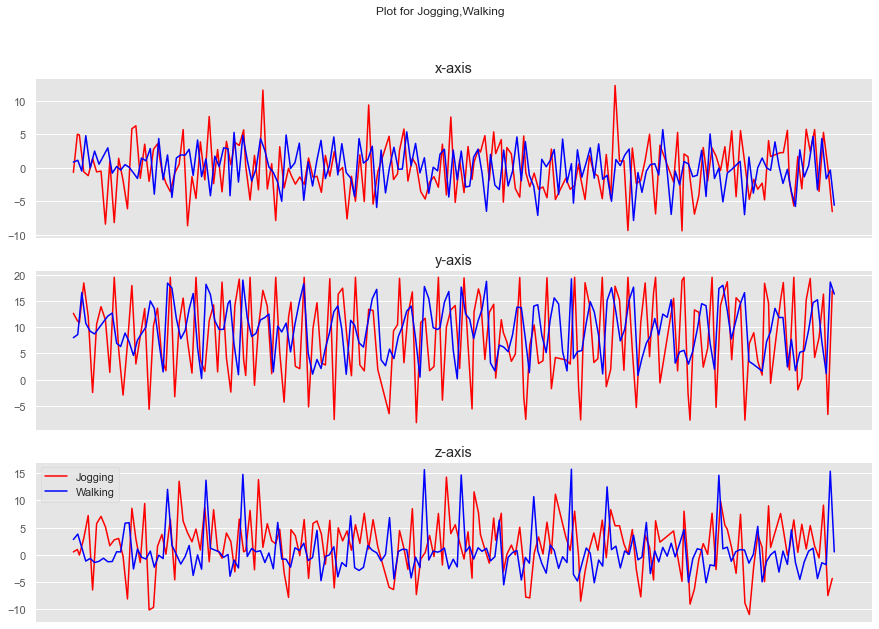

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(15, 10),sharex=True)

colors = ["red","blue","cyan","green","black","yellow","magenta"]
colors.reverse()
max_time = 0
activities = ['Jogging', 'Walking']
for activity in activities:
  subset = df[df["activity"] == activity][:180]
  min_timestamp = subset['timestamp'].min()
  t_stamp = subset['timestamp'].copy()-min_timestamp
  color = colors.pop()
  if max_time<t_stamp.max():
    max_time = t_stamp.max()
  plot_axis(ax0, t_stamp, subset['x-axis'], 'x-axis',color=color,label=activity)
  plot_axis(ax1, t_stamp, subset['y-axis'], 'y-axis',color=color,label=activity)
  plot_axis(ax2, t_stamp, subset['z-axis'], 'z-axis',color=color,label=activity)


# ax0.set_ylim([0, max_time])
ax0.grid(True)
# plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(top=0.90)
fig.suptitle("Plot for "+','.join(activities))
plt.legend()
plt.show()


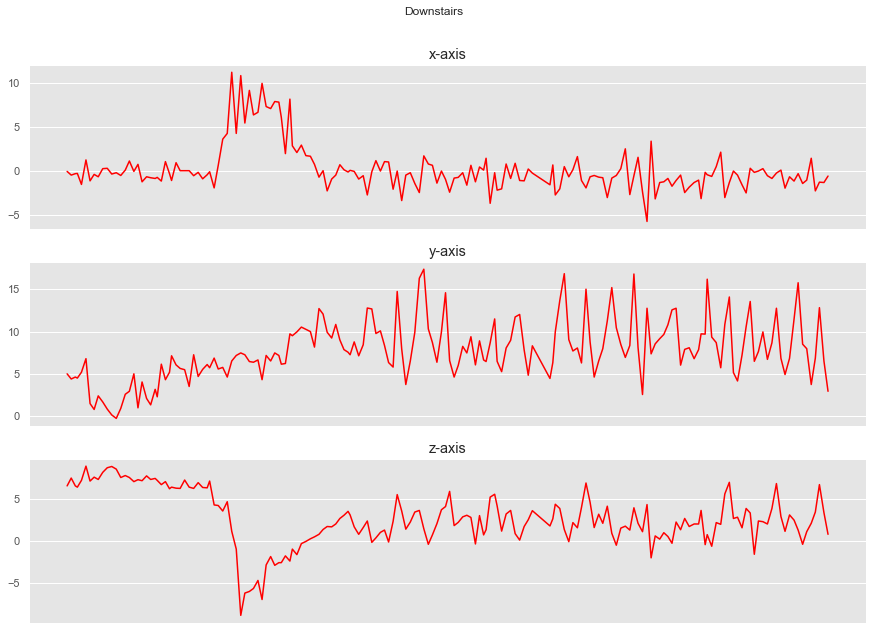

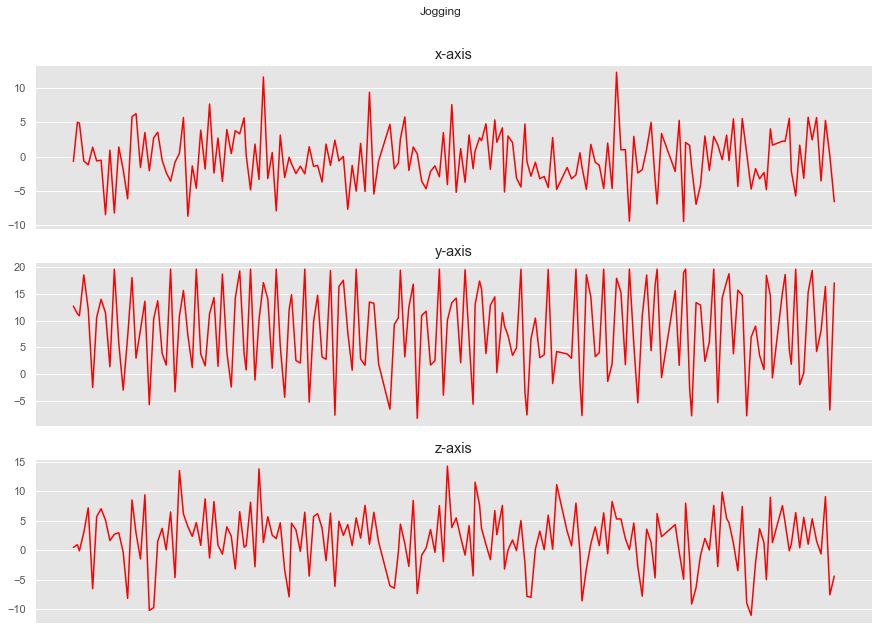

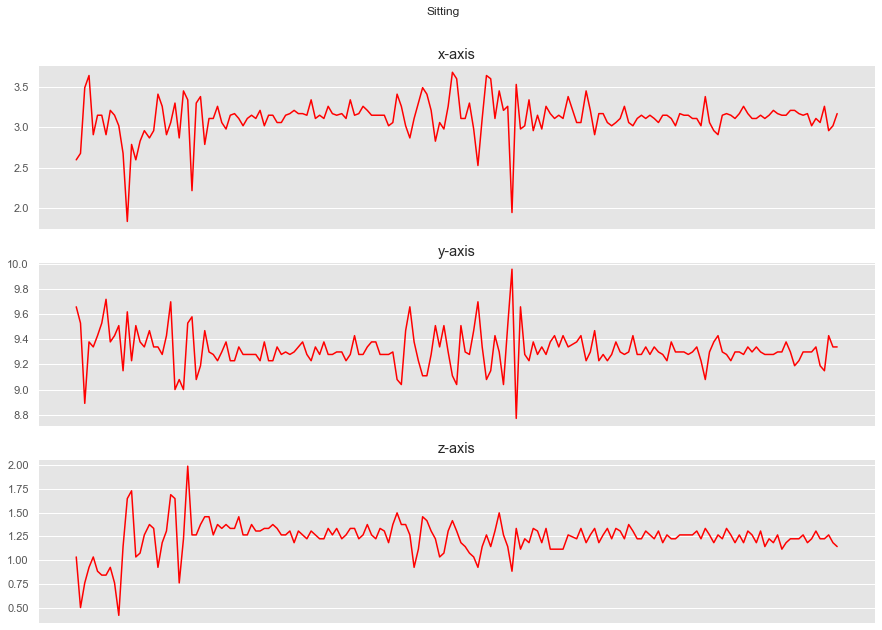

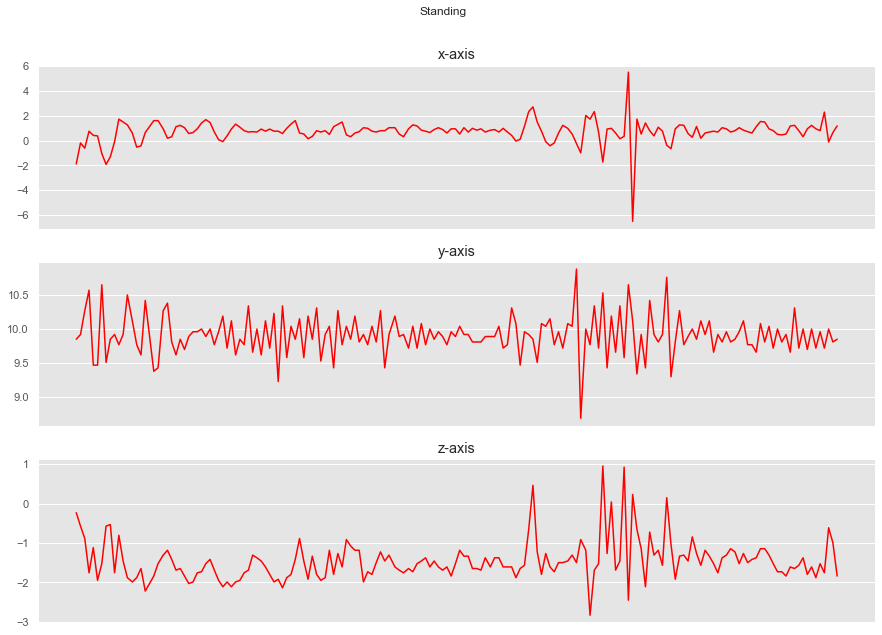

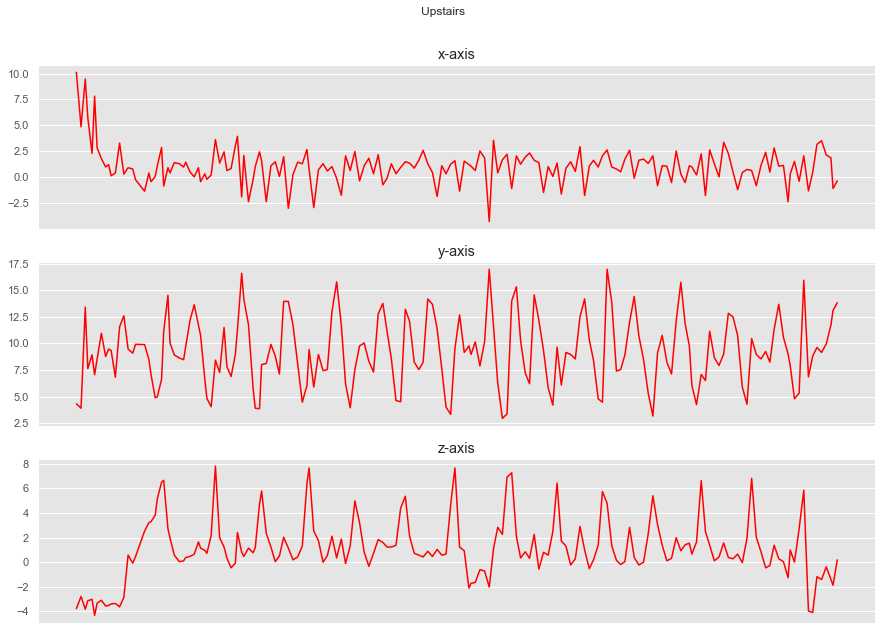

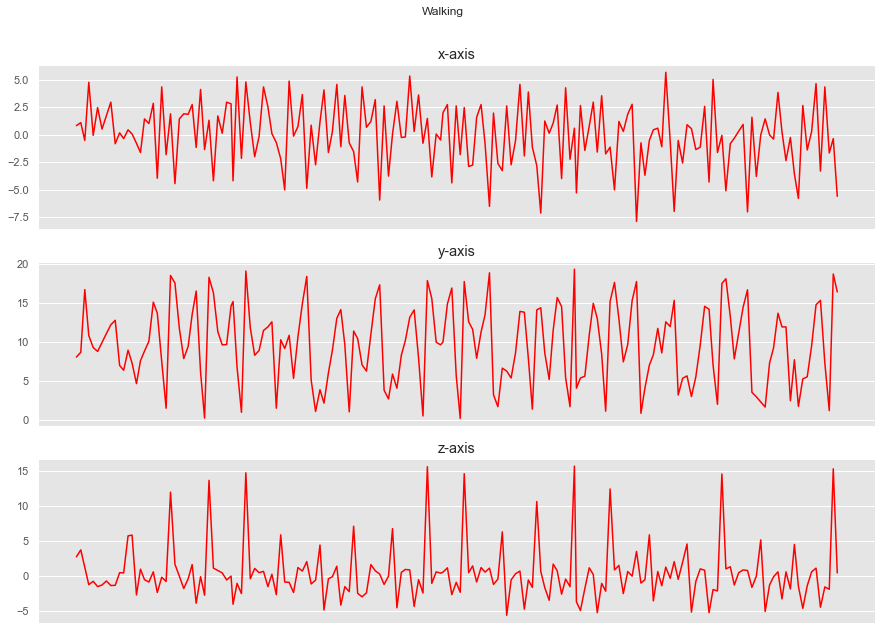

In [19]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [20]:
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])

# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6}) # Why is this done rounding -------- NEed to check
df_train.head()


--- Reshape the data into segments ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,-0.0,0.4,-0.2,5
8490,17,Walking,57870012316000,-0.1,0.4,-0.2,5
8491,17,Walking,57870122301000,-0.1,0.4,-0.2,5
8492,17,Walking,57870222246000,-0.1,0.4,-0.2,5
8493,17,Walking,57870332292000,-0.1,0.4,-0.2,5


In [26]:
# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS, # 80
                                              STEP_DISTANCE, #40
                                              LABEL)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
len(x_train),(len(df_train)-80)/40

(20868, 20867.5)

In [23]:
# %%
print(x_train.shape)
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)

(20868, 80, 3)

--- Reshape data to be accepted by Keras ---

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 240)
input_shape: 240
New y_train shape:  (20868, 6)


In [68]:
_,n_timesteps, n_features = x_train.shape
n_outputs = num_classes

In [72]:
y_train = np_utils.to_categorical(y_train, num_classes)

In [66]:
y_train.shape[1]

IndexError: tuple index out of range

In [74]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
20868/20868 [==============================] - 6s 273us/step - loss: 0.3572 - accuracy: 0.8750
Epoch 2/10
20868/20868 [==============================] - 6s 295us/step - loss: 0.1731 - accuracy: 0.9409
Epoch 3/10
20868/20868 [==============================] - 6s 311us/step - loss: 0.1257 - accuracy: 0.9578
Epoch 4/10
20868/20868 [==============================] - 6s 289us/step - loss: 0.0946 - accuracy: 0.9684
Epoch 5/10
20868/20868 [==============================] - 6s 273us/step - loss: 0.0708 - accuracy: 0.9758
Epoch 6/10
20868/20868 [==============================] - 6s 290us/step - loss: 0.0574 - accuracy: 0.9806
Epoch 7/10
20868/20868 [==============================] - 10s 476us/step - loss: 0.0471 - accuracy: 0.9842
Epoch 8/10
20868/20868 [==============================] - 7s 327us/step - loss: 0.0373 - accuracy: 0.9876
Epoch 9/10
20868/20868 [==============================] - 5s 250us/step - loss: 0.0310 - accuracy: 0.9892
Epoch 10/10
20868/20868 [====================


--- Check against test data ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind


--- Confusion matrix for test data ---



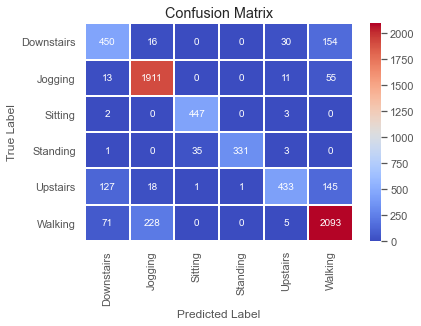

In [76]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [24]:
TIME_PERIODS,num_sensors,input_shape,num_classes

(80, 3, 240, 6)

In [60]:
x_train.shape

(20868, 80, 3)

In [74]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,))) # converting 240 back to 80x3
model_m.add(Conv1D(3, 16, activation='relu', input_shape=(TIME_PERIODS,num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

#3, 16
model_m.add(Conv1D(3, 16, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(BatchNormalization())

# 64
#network.add(GlobalAveragePooling1D())
model_m.add(Flatten())
#network.add(Dropout(0.1))
model_m.add(Dense(units=64, activation='relu',
                         kernel_regularizer=regularizers.l2(0.1)))

model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
# model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
# model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(num_classes, activation='softmax'))
# print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%


--- Create neural network model ---

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 65, 3)             147       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 21, 3)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 3)             12        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 6, 3)              147       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 3)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 3)              12        
_________________________________________________________________
flatten_5 (Flatt

In [75]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
#     keras.callbacks.EarlyStopping(monitor='acc', patience=1)
# ]
callbacks_list = [
    keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


--- Fit the model ---



ValueError: Error when checking target: expected dense_10 to have shape (6,) but got array with shape (1,)

# print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
print(history.history.keys())
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [0]:
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])



--- Check against test data ---



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

6584/6584 [==============================] - 0s 36us/step

Accuracy on test data: 0.86

Loss on test data: 0.52



--- Confusion matrix for test data ---



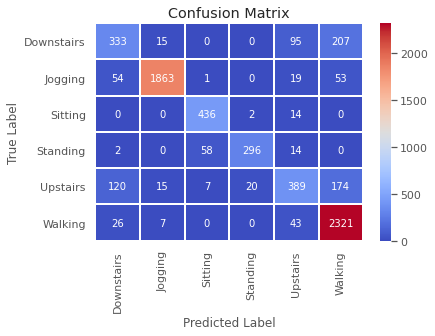

In [0]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)


In [0]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       650
           1       0.98      0.94      0.96      1990
           2       0.87      0.96      0.91       452
           3       0.93      0.80      0.86       370
           4       0.68      0.54      0.60       725
           5       0.84      0.97      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.85      0.86      0.85      6584



In [1]:
import pickle 

with open('tmp/x_test.pickle','wb+') as fd:
  # datasetObj = {"x_test":x_test,"y_test":y_test,"x_train":x_train,"y_train":y_train}
  pickle.dump(x_test,fd)

with open('tmp/y_test.pickle','wb+') as fd:
  pickle.dump(y_test,fd)

with open('tmp/x_train.pickle','wb+') as fd:
  pickle.dump(x_train,fd)

with open('tmp/y_train.pickle','wb+') as fd:
  pickle.dump(y_train,fd)



NameError: name 'x_test' is not defined

In [0]:
! mkdir tmp

In [0]:
!ls tmp

x_test.pickle  x_train.pickle  y_test.pickle  y_train.pickle


In [67]:
num_classes

6

In [78]:
from keras import metrics

metrics

In [79]:
dir(metics)

NameError: name 'metics' is not defined